##Paquetes

In [1]:
%%capture
!pip install rdkit

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.DataStructs import FingerprintSimilarity
from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist

##Carga del CSV

In [5]:
df = pd.read_csv('file.csv', sep = ',')

##Huellas dactilares

In [14]:
#Convierte los SMILES del df a MACCS keys
def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return rdMolDescriptors.GetMACCSKeysFingerprint(mol)

df['MACCS'] = df['SMILES'].apply(smiles_to_maccs) #Aplica la función al df y crea una nueva columna para guardar los resultados

#Función para calcular los coeficientes de Tanimoto medios de cada grupo
def calculate_median_tanimoto(group):
    fingerprints = list(group['MACCS'])
    num_compounds = len(fingerprints)
    tanimoto_coefficients = [] #Para guardar los coeficientes de Tanimoto

    for i in range(num_compounds): #Toma una molécula
        for j in range(i + 1, num_compounds):  #Y la compara con cada molécula. Se usa i+1 para evitar cálculos duplicados
            similarity = FingerprintSimilarity(fingerprints[i], fingerprints[j])
            tanimoto_coefficients.append(similarity)
    return np.median(tanimoto_coefficients) if tanimoto_coefficients else None #Calcula el promedio de los coeficientes de Tanimoto

summary = df.groupby('SET', as_index=False).apply(calculate_median_tanimoto, include_groups=False) #Agrupa los compuestos por conjunto y aplica la función para calcular los coef. de Tanimoto
summary.columns = ['SET', 'Median_Tanimoto'] #Guarda los resultados en un df de resumen

##Andamios moleculares

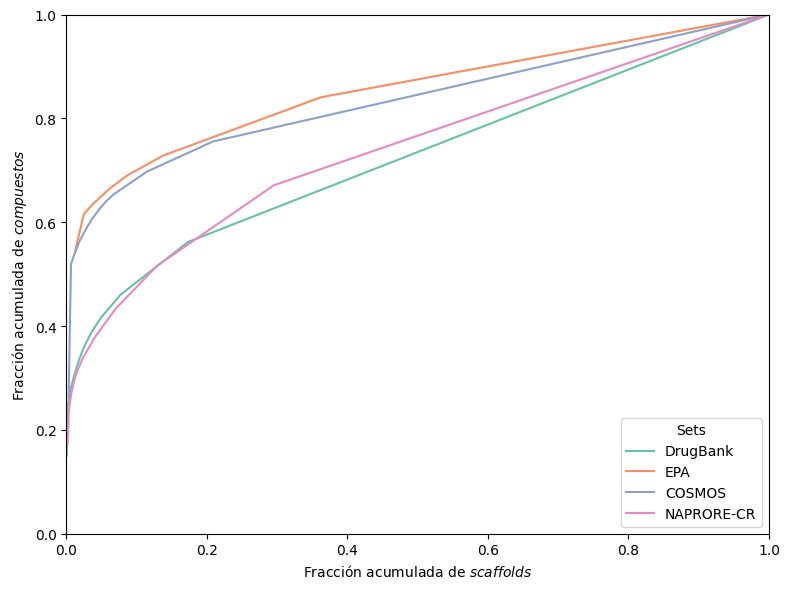

In [15]:
def get_scaffold(smiles): #Función para obtener los andamios de cada molécula
    mol = Chem.MolFromSmiles(smiles) #Toma un SMILES y lo convierte en mol
    if mol is not None:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol) #Los genera a partir del objeto mol
        return Chem.MolToSmiles(scaffold)
    return None

df['SCAFFOLD'] = df['SMILES'].apply(get_scaffold) #Aplica la función al df y crea una nueva columna para guardar los resultados

#Revisa cuántos compuestos no tienen andamios
missing_scaffolds = df['SCAFFOLD'].isnull().sum()
if missing_scaffolds > 0:
    print(f"ERROR: {missing_scaffolds} compounds will not have a scaffold.")
df = df.dropna(subset=['SCAFFOLD']) #Los elimina del df

grouped = df.groupby(['SET', 'SCAFFOLD']).size().reset_index(name='FREQUENCY') #Agrupa por conjunto y calcula frecuencias de cada andamio
total_molecules = grouped.groupby('SET')['FREQUENCY'].sum().reset_index(name='TOTAL_MOLECULES') #Calcula el total de compuestos de cada conjunto
grouped = pd.merge(grouped, total_molecules, on='SET') #Añade las frecuencias de andamio y el total de moléculas a cada set

#Calcula la frecuencia acumulada de andamios por set
grouped = grouped.sort_values(['SET', 'FREQUENCY'], ascending=[True, False]) #Agrupa por set y los ordena por frecuencia
grouped['CUMULATIVE_COMPOUND_COUNT'] = grouped.groupby('SET')['FREQUENCY'].cumsum() #Calcula la suma acumulada de frecuencias por set
grouped['CUMULATIVE_COMPOUND_FRACTION'] = grouped['CUMULATIVE_COMPOUND_COUNT']/grouped['TOTAL_MOLECULES'] #Calcula la fracción de compuestos representados

#Calcula la fracción acumulada de compuestos
unique_scaffolds = grouped.groupby('SET')['SCAFFOLD'].count().reset_index(name='UNIQUE_SCAFFOLDS') #Agrupa por set y cuenta la cantidad de andamios únicos
grouped = pd.merge(grouped, unique_scaffolds, on='SET') #Añade al df 'grouped' para guardar el valor
grouped['CUMULATIVE_SCAFFOLD_COUNT'] = grouped.groupby('SET').cumcount() + 1 #Asigna un número a cada andamio único a partir del 1
grouped['CUMULATIVE_SCAFFOLD_FRACTION'] = grouped['CUMULATIVE_SCAFFOLD_COUNT'] / grouped['UNIQUE_SCAFFOLDS'] #Calcula la fracción de andamios representados

#Grafica las curvas de recuperación cíclica del sistema
plt.figure(figsize=(8, 6))

#Define el orden deseado de conjuntos y sus colores respectivos
set_order = ['DrugBank approved', 'EPA natural pesticides', 'COSMOS cosmetic ingredients', 'NAPRORE-CR']
colors = sns.color_palette("Set2", n_colors=len(set_order))

#Abreviaturas de los conjuntos
set_name_map = {'DrugBank approved': 'DrugBank', 'EPA natural pesticides': 'EPA', 'COSMOS cosmetic ingredients': 'COSMOS', 'NAPRORE-CR': 'NAPRORE-CR'}

#Grafica con los colores y nombres definidos
for i, set_name in enumerate(set_order): #Para cada conjunto de la lista ordenada
    group = grouped[grouped['SET'] == set_name] #Toma un conjunto según la lista ordenada de nombres
    plt.plot(group['CUMULATIVE_SCAFFOLD_FRACTION'], group['CUMULATIVE_COMPOUND_FRACTION'], label=set_name_map[set_name], color=colors[i]) #Grafica la curva a partir de las fracciones acumuladas de compuestos y andamios

plt.xlabel("Fracción acumulada de $\it{scaffolds}$")
plt.ylabel("Fracción acumulada de $\it{compuestos}$")
plt.legend(title='Sets', loc='lower right')
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.tight_layout()

#Guarda la figura
plt.savefig('CSR.png', dpi=300, bbox_inches='tight')

plt.show()

In [16]:
#Calcula el AUC de cada curva por el método del trapecio
auc_values = {}
for name, group in grouped.groupby('SET'):
    x = group['CUMULATIVE_SCAFFOLD_FRACTION']
    y = group['CUMULATIVE_COMPOUND_FRACTION']
    auc = np.trapz(y, x)
    auc_values[name] = auc

#Guarda los AUC en un df y lo combina en el de resumen
auc_df = pd.DataFrame(list(auc_values.items()), columns=['SET', 'AUC'])
summary = pd.merge(summary, auc_df, on='SET', how='outer')

##Propiedades fisicoquímicas

In [ ]:
#Función para calcular la distancia Euclideana intra-set a partir de los descriptores
scaler = StandardScaler()

def mean_intra_set_distance(group):
    descriptors = group[['MW', 'HBD', 'HBA', 'RB', 'AlogP', 'TPSA', 'AG', 'BG']]
    descriptors_scaled = scaler.fit_transform(descriptors) #Normaliza los descriptores
    distances = pdist(descriptors_scaled, metric='euclidean')  #Calcula las distancias entre pares
    return np.mean(distances) if distances.size > 0 else None #Calcula el promedio de las distancias

mean_distances = df.groupby('SET').apply(mean_intra_set_distance).reset_index(name='Mean_Intra_Set_Distance') #Agrupa por conjunto y calcula la distancia Euclideana intra-set promedio
summary = pd.merge(summary, mean_distances, on='SET', how='outer') #Añade las distancias medias al resumen

##Tamaño del conjunto

In [19]:
#Cuenta el tamaño de cada conjunto
set_sizes = df['SET'].value_counts().reset_index() #Genera un df a partir del original y cuenta cuántas veces aparece cada conjunto en este
set_sizes.columns = ['SET', 'Size'] #Cambia el nombre antes de incoporar al resumen
summary = pd.merge(summary, set_sizes, on='SET', how='outer')

##Gráfico de diversidad consensuada

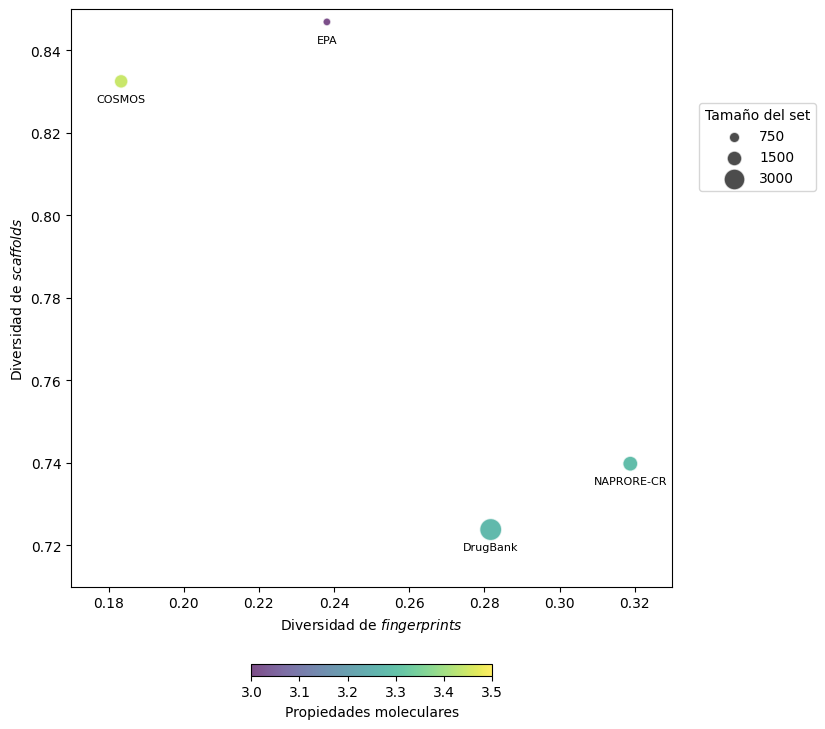

In [21]:
plt.figure(figsize=(8.5, 8))

#Grafica un gráfico de dispersión
scatter = plt.scatter(
    data = summary,
    x = 'Median_Tanimoto',
    y = 'AUC',
    s = summary['Size'] * 0.1, #Escala para mejorar visibilidad
    c = 'Mean_Intra_Set_Distance',  #El color del punto se define por su distancia intra-set
    cmap='viridis',
    alpha=0.7,
    edgecolor='w',
    vmin=3, vmax=3.5)

#Añade la escala de color horizontal debajo del gráfico
cbar = plt.colorbar(scatter, orientation='horizontal', shrink=0.4, pad=0.10)
cbar.set_label('Propiedades moleculares')

plt.xlabel('Diversidad de $\it{fingerprints}$')
plt.ylabel('Diversidad de $\it{scaffolds}$')

#Límites ajustados para mejorar visibilidad
plt.xlim(0.17, 0.33)
plt.ylim(0.71, 0.85)

#Leyenda con escala personalizada para el tamaño de punto
size_scale = [750, 1500, 3000]
handles = [plt.scatter([], [], s=size * 0.075, c='k', alpha=0.7, edgecolor='w') for size in size_scale]
labels = [f'{size}' for size in size_scale]
plt.legend(handles=handles, labels=labels, title='Tamaño del set', loc='upper right', bbox_to_anchor=(1.25, 0.85), frameon=True)

#Añade el nombre del set a cada punto
for i, row in summary.iterrows():
    set_name = set_name_map.get(row['SET'], row['SET'])
    plt.annotate(set_name, (row['Median_Tanimoto'], row['AUC']), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=8)

plt.tight_layout()

#Guarda el gráfico
plt.savefig('CDP.png', dpi=300, bbox_inches='tight')

plt.show()